In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
import numpy as np

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torchsummary import summary

In [ ]:
!pip install --upgrade kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

100%|██████████| 675M/675M [00:07<00:00, 92.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


In [ ]:
print(os.listdir(os.path.join(path, 'cell_images')))

['Uninfected', 'cell_images', 'Parasitized']


In [ ]:
unifected_cells = '/root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected'
parasitized_cells = '/root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized'

In [ ]:
print(os.listdir(unifected_cells))

['C215ThinF_IMG_20151106_133116_cell_75.png', 'C82P43ThinF_IMG_20150817_124418_cell_121.png', 'C188P149ThinF_IMG_20151203_134449_cell_92.png', 'C208ThinF_IMG_20151029_155436_cell_125.png', 'C130P91ThinF_IMG_20151004_141504_cell_9.png', 'C58P19thinF_IMG_20150802_122846_cell_111.png', 'C2NThinF_IMG_20150604_114751_cell_113.png', 'C105P66ThinF_IMG_20150924_095130_cell_44.png', 'C112P73ThinF_IMG_20150930_131659_cell_54.png', 'C175P136NThinF_IMG_20151127_142009_cell_147.png', 'C158P119ThinF_IMG_20151115_181136_cell_101.png', 'C47P8thinOriginalOlympusCX21_IMG_20150717_173515_cell_116.png', 'C127P88ThinF_IMG_20151004_112004_cell_67.png', 'C55P16thinF_IMG_20150728_121151_cell_91.png', 'C56P17thinF_IMG_20150728_160623_cell_53.png', 'C152P113ThinF_IMG_20151115_124217_cell_106.png', 'C180P141NThinF_IMG_20151201_165601_cell_147.png', 'C205ThinF_IMG_20151106_151622_cell_97.png', 'C64P25N_ThinF_IMG_20150818_152455_cell_54.png', 'C181P142ThinF_IMG_20151127_160514_cell_37.png', 'C165P126ThinF_IMG_2015

In [ ]:
cell_to_num = {
    0: 'Uninfected',
    1: 'Parasitized'
}

In [ ]:
print(f'Unifected Cell Images: {len(os.listdir(unifected_cells))}')
print(f'Parasitized Cell Images: {len(os.listdir(parasitized_cells))}')

Unifected Cell Images: 13780
Parasitized Cell Images: 13780


In [ ]:
def load_image_label(image_folder, label, image_size=(64, 64)):
    images = []
    labels = []

    # Creating a list of files in directory
    file_list = os.listdir(image_folder)

    for i in tqdm(range(len(file_list)), desc="Loading Data"):
        # Index the file from the list
        filename = file_list[i]
        # print(f'Filename: {filename}')

        # Construct the full path
        file_path = os.path.join(image_folder, filename)
        # print(f'File Path: {file_path}')
        # input()

        # Turning the path into an imgage
        image = cv2.imread(file_path)


        # Skip if image couldn't be loaded
        if image is None:
            print(f"Skipping {file_path} - could not be loaded")
            continue

        # Resize the image to 64, 64
        image = cv2.resize(image, image_size)

        # Convert from BGR to RGB (OpenCV loads as BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalize pixel values to 0-1
        image = image / 255.0

        # Append to lists
        images.append(image)
        labels.append(label)

    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

In [ ]:
uninfected_images, unifected_label = load_image_label(unifected_cells, 0)
parasitized_images, parasitized_label = load_image_label(parasitized_cells, 1)


Loading Data:  95%|█████████▍| 13072/13780 [00:16<00:00, 1563.09it/s]

Skipping /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/Thumbs.db - could not be loaded


Loading Data:  94%|█████████▍| 12961/13780 [00:12<00:00, 1462.52it/s]

Skipping /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/Thumbs.db - could not be loaded


Loading Data: 100%|██████████| 13780/13780 [00:13<00:00, 1048.21it/s]


In [ ]:
print(f'Unifected Images: {uninfected_images.shape}') # We lost an image most likely because it was bad
print(f'Unifected Labels: {unifected_label.shape}')
print(f'Parasitized Images: {parasitized_images.shape}')
print(f'Parasitized Labels: {parasitized_label.shape}')

Unifected Images: (13779, 64, 64, 3)
Unifected Labels: (13779,)
Parasitized Images: (13779, 64, 64, 3)
Parasitized Labels: (13779,)


In [ ]:
images = np.concatenate((uninfected_images, parasitized_images), axis=0) # The images ARE NOT SUFFLED, WHEN YOU CREATE DATALOADER SHUFFLE THEM
# Right now they are all uninfected images then allparasitized (This is not good when training)
labels = np.concatenate((unifected_label, parasitized_label), axis=0)

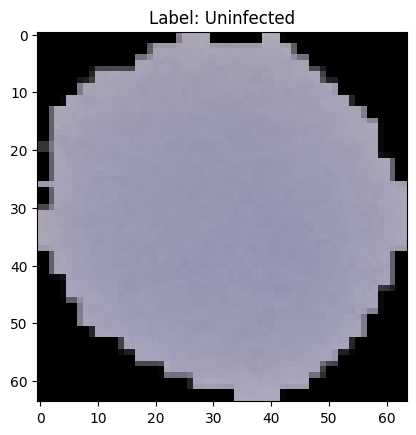

In [ ]:
image_num = 1800 #@param {type:"raw"}
plt.imshow(images[image_num])
plt.title(f'Label: {cell_to_num[labels[image_num]]}')
plt.show()

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.fully_connected = nn.Sequential(
        nn.Linear(in_features=256*4*4, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=2),
    )

    self.flatten = nn.Flatten()


  def forward(self, x):
    x = self.conv_layers(x)
    x = self.flatten(x)
    x = self.fully_connected(x)
    return x

model = ConvNet()  # Create an instance of the model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model.to(device)
summary(model, (3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
       BatchNorm2d-2           [-1, 16, 64, 64]              32
              ReLU-3           [-1, 16, 64, 64]               0
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           9,280
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
        MaxPool2d-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         295,168
      BatchNorm2d-14            [-

In [ ]:
print(images.shape)

(27558, 64, 64, 3)


In [ ]:
all_images = torch.tensor(images)
all_images = all_images.permute(0, 3, 1, 2) # Change form (Batch, Height, Width, Channel) to (B, C, H, W)

all_labels = torch.tensor(labels)

In [ ]:
print(all_images.shape)
print(all_labels.shape)


torch.Size([27558, 3, 64, 64])
torch.Size([27558])


In [ ]:
train_images = all_images[:20000]
train_labels = all_labels[:20000]

test_images = all_images[20000:]
test_labels = all_labels[20000:]

In [ ]:
train_set = TensorDataset(train_images, train_labels)
test_set = TensorDataset(test_images, test_labels)

In [ ]:
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=False) # The dataloader is an iterable (CAN NOT INDEX IT)

In [ ]:
images, labels = next(iter(train_dataloader)) # You have to turn it into an iterable and then you can index it
print(f'Shape of the images: {images.shape}')
print(f'Shape of the labels: {labels.shape}')
print(f'Number of batches is: {len(iter(train_dataloader))}')

Shape of the images: torch.Size([32, 3, 64, 64])
Shape of the labels: torch.Size([32])
Number of batches is: 625


In [ ]:
625*32

20000

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
for i in range(50):
  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
def train_loop(train_dataloader, model, loss_fn, optimizer, epochs):
  model.train() # Put the model in training mode
  train_loss = []
  for epoch in range(epochs):
    train_loss_epoch = 0
    for image, label in tqdm(train_dataloader, desc="Training Model"):
      image, label = image.to(device), label.to(device)

      label = label.long() # This just means we're turning it into a int 64 (bit size)

      # print(image.dtype)
      # print(label.dtype)
      # input()

      optimizer.zero_grad()

      pred = model(image)
      # print(pred)
      # print(pred.shape)
      # print(label.shape)
      # input()

      loss = loss_fn(pred, label) # Prediction has to go first (Calculate loss between the prediction and the true value)
      loss.backward()
      train_loss_epoch += loss.item()

      optimizer.step()

    avg_loss = train_loss_epoch / len(train_dataloader)
    train_loss.append(avg_loss)

    print(f'Epoch: {epoch+1} | Loss: {avg_loss:.4f}')

  return train_loss


In [ ]:
num_epochs = 3
losses = train_loop(train_dataloader, model, loss_fn, optimizer, epochs=num_epochs) # Lets take a few minute break while it trains and we will come back

Training Model: 100%|██████████| 625/625 [00:04<00:00, 126.29it/s]


Epoch: 1 | Loss: 0.1121


Training Model: 100%|██████████| 625/625 [00:04<00:00, 135.90it/s]


Epoch: 2 | Loss: 0.1070


Training Model: 100%|██████████| 625/625 [00:04<00:00, 132.37it/s]

Epoch: 3 | Loss: 0.1010


In [ ]:
print(losses)

[0.11205424959808588, 0.10700642832070589, 0.1010253401607275]


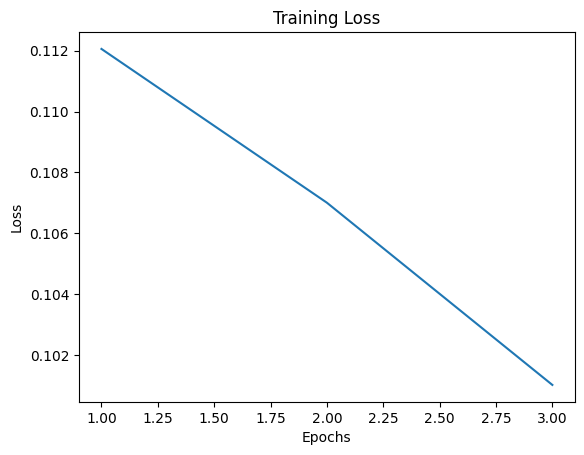

In [ ]:
epoch_list = list(range(1, num_epochs+1))
plt.plot(epoch_list, losses)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
def accuracy(correct, total):
  return correct/total * 100

In [ ]:
def test_loop(test_dataloader, model):
  model.eval() # Put the model in evaluation mode
  correct = 0
  total = 0

  with torch.no_grad():
    for image, label in tqdm(test_dataloader, desc="Testing Model"):
      image, label = image.to(device), label.to(device)
      label = label.long()

      pred = model(image)

      correct += (pred.argmax(1) == label).type(torch.float).sum().item()
      total += len(label)

    print(f'Accuracy: {accuracy(correct, total)}')

In [ ]:
test_loop(test_dataloader, model)

Testing Model: 100%|██████████| 237/237 [00:00<00:00, 305.52it/s]

Accuracy: 93.53003440063509


In [ ]:
image_num = 6002 #@param {type:"raw"}
testing_image = test_images[image_num]
testing_label = test_labels[image_num]

In [ ]:
testing_image = testing_image.to(device)

In [ ]:
print(testing_image.shape)

torch.Size([3, 64, 64])


torch.Size([1, 2])


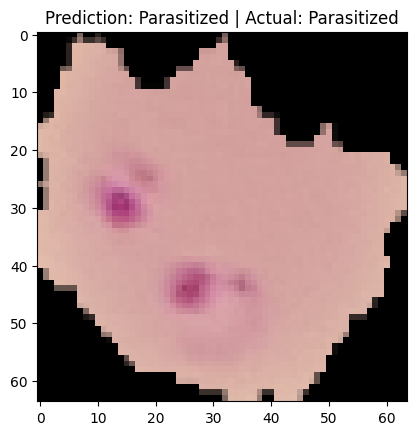

In [ ]:
with torch.no_grad():
  pred = model(testing_image.unsqueeze(0))
  print(pred.shape)

plt.imshow(testing_image.cpu().permute(1, 2, 0))
plt.title(f'Prediction: {cell_to_num[pred.argmax(1).item()]} | Actual: {cell_to_num[testing_label.item()]}')
plt.show()